# Digital Advertisement under Uncertainty



Digital advertising is a multi-billion dollar industry, amassing more than \\$380bi in 2022, with just Alphabet and Meta being responsible for \\$234bi [1]. This sizeable digital market is powered by high-performance marketing strategies developed by analysis of the advertisement environment and the Lifetime Value (LTV) estimation of customers. The LTV is arguably the most vital metric to conduct a profitable advertisement strategy because it determines how much we are willing to pay for them. After all, if we pay more than the users are worth, we are effectively losing money. 

But while the upper limit for the *Cost per User* is clear, its optimal point is not so readily determined: it depends on how many users we expect to obtain for a given *Cost per User* and how accurate the LTV estimation is. However, forecasting the LTV of marketing campaigns has challenges that are not often seen in machine learning problems:
1) LTV is zero-inflated since most users who become mobile game players or register as customers in a store never spend a single cent.
2) The distribution of the LTV of those that do purchase something is highly skewed, i.e., most of the revenue is generated by a fraction of the users.
3) The distribution of the LTV itself changes over time, requiring the prediction algorithms to adapt quickly.
4) The marketing industry is constantly changing, with some harming the accuracy of the LTV estimation, such as Apple's App Tracking Transparency (ATT).

In this context, we explain why estimating your users' LTV uncertainty matters to achieve maximum profitability and how that can be accomplished. The **first part** of this series explains one way we can model the digital advertisement environment and how different assumptions of the *Volume Function* impact the optimal bidding strategy when we have uncertainty on our LTV estimates (which is always).

In the **second part**, we introduce a code to forecast the LTV of the marketing campaigns using PySTAN. PySTAN is a Python interface to STAN, a package for Bayesian inference capable of high-performance statistical computation. This computation speed is essential in a marketing context, where we need to predict the LTV of multiple marketing campaigns over a long period while estimating the LTV distribution. We demonstrate how to implement a PySTAN model to predict a time series using the [Lifetime Value data from Kaggle](https://www.kaggle.com/datasets/baetulo/lifetime-value?resource=download) in less than 2 minutes. This data contains user-level information of customers joining a website, such as their country, credit card level, a product acquired when they entered the website, short-term value, and (of course) their lifetime value. We transform this user-level data into segment-level by grouping users to simulate a marketing campaign. We finish by explaining how to implement the equivalent model in PyMC, a probabilistic programming library for Python, and comparing the pros and cons of both alternatives.



# Part 1: Why LTV uncertainty matters


### TL:DR (Too long, didn't read)


- The *Volume Function*, i.e. how many users you get for a given *Cost per User*, is crucial in determining the optimal *Cost per User*
- The derivate of the *Volume Function* around the optimal *Cost per User* and the uncertainty on the LTV estimate defines how much less we should bid from where you would bid, were uncertainty (i.e., the standard error of the prediction) 0
- Depending on the *Volume Function* and uncertainty on the LTV, it may be worth bidding even 20% less than the optimal value if we had no uncertainty on the LTV value


The rest of this document is organized into the following sections:

1) **Modelling digital advertisement**: we explain the model for the operation of marketing campaigns in a digital platform and state that it has one goal: maximum profit. Initially, we define profit simply as the difference between earnings and cost, but then break those metrics down in LTV, *Cost per User*, and the number of users.
2) **The *Volume Function***: The number of users acquired through a marketing campaign is defined by a function named *Volume Function* and its single input: the *Cost per User*. We describe the requirements for the *Volume Function* and introduce one possible solution.
3) **The profit curve, how the expected profit varies per *Cost per User*:** With the volume function defined, we show how the profit for a given marketing campaign varies depending on the average *Cost per User*, if the LTV is kept constant
4) **The error associated with the predicted LTV**: with the marketing model defined, we only need to determine the error associated with LTV. We assume it to be normally distributed around 0 and explain why that is a reasonable assumption
5) **The optimal bidding strategy under uncertainty**: finally, we demonstrate how the error of  LTV impacts the profitability of marketing campaigns and demonstrate which bidding strategy outperforms for different levels of LTV error and *Volume Functions*
6) **Conclusion**: we reinforce the reasons why estimating the uncertainty of LTV is vital to achieve high profitability in marketing campaigns and which strategy one should follow for each situation


## 1- Modelling digital advertisement

The digital advertisement is rich with methods on how a monetary quantity (a bid, a bid cap, a budget, etc.) is connected to how many users - or leads, conversions, installs, subscribers - an advertiser acquires. For simplicity and without loss of generalization, we define for the rest of the document that we are reaching users for a digital product and use *Cost per User* as the lever that controls the volume (i.e., the quantity of the desired unit) acquired through advertisement, which can be easily exchanged to a bid or ROAS (Revenue over Ad Spend).

In a digital advertisement, the ultimate goal is to obtain a profit from the marketing campaign, defined as

$$ Profit \triangleq Revenue - Costs$$

, where $Revenue$ and $Cost$ can be further broken down:

$$ Profit = Users * (LTV_{user} - Cost_{user})$$

, where $Users$ stands for the number of users acquired from the marketing campaign, and $LTV_{user}$ and $Cost_{user}$ for the average LTV and Cost of those users, respectively.

But the number of users acquired from a marketing campaign depends on the digital platform, the advertised product, and how many we will put for a user. We are going to call this relationship *Volume Function* $f\left(Cost_{user}\right)$:

$$ Installs \triangleq f\left(Cost_{user}\right)$$

The resulting $Profit$ function thus becomes:

$$ Profit = f\left(Cost_{user}\right) * (LTV_{user} - Cost_{user})$$

And if the volume function and $LTV_{user}$ are known, the $Cost_{user}$ that delivers the highest $Profit$ can be found using an optimization function as [scipy.optimize.minimize] in Python. However, as we will show, it is less obvious when $LTV_{user}$ is uncertain.

## 2- The *Volume Function*: how the *Cost per User* defines the acquired number of users


In the previous section, we introduced the *Volume Function* $f(x)$ but didn't go into much detail. As this function defines the association between *Cost per User* and the number of users from a marketing campaign, it has to satisfy the following conditions:

- $f(x)$ = 0, $\forall x \leq 0 $,
  - This is quite simple: an advertising platform will only show an ad to its user if it gains
- $f(x)$ is strictly monotonically non-decreasing
  - When we advertise on a platform, we first reach users not highly valued by other advertisers or who have a good match with our product. All else constant, the only way to get new customers is by paying a higher price *for those additional users* to win against the current winners. As a consequence, the average *Cost per User* increases.
- $\lim_{x \to \infty} = D$
  - This condition states that a marketing platform has a maximum number of people we can reach, regardless of size. In the case of Meta and Google, this limit can be in the order of billions.


While many functions satisfy the requirements above, a simple one is the cumulative probability function of a log-normal distribution multiplied by a constant:

$$f\left(Cost_{user}\right)_{Log-Norm Distribution} = User_{Limit}*CDF_{log-norm}(Cost_{user}, \mu, \sigma)$$



where $CDF_{Log-Norm Distribution}$ refers to the cumulative probability function of a log-normal distribution.
While $ User_{limit}$ is unknown to the advertiser, it can be estimated from previous marketing campaigns:

$$Install_{Ref} =  User_{Limit}*CDF_{log-norm}(Cost_{user, reference}, \mu, \sigma)$$

$$User_{Limit} = \frac{Install_{Ref}}{CDF_{log-norm}(Cost_{user, reference}, \mu, \sigma)}$$


We will show for different log-normal distributions how the volume should vary per $Cost_{user}$, and, consequently, the profit curve and the optimal bidding point. For that, we fix the following variables.

$$Cost_{user, reference} = 2$$
$$E[LTV] = 2$$
$$Install_{Ref} = 1000$$

In addition, we will consider four different log-normal distributions for the *Volume Function*, with expected values of 0.5, 1.0, 1.5, and 2 and a standard deviation of 0.5 (for the normal distribution).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from typing import List

from src.VolumeAcquisition import CumulativeLognormalVolume

sns.set_style('whitegrid')
PLOT_WITHD_INCHES = 20
PLOT_HEIGHT_INCHES = 10

In [25]:
# The fixed parameters specified before
reference_volume = 1000
reference_cpi = 2.0
reference_ltv = 2.0

lognormal_exp_values = [0.5, 1, 1.5, 2.0] # the expected values for the 
cpi_range = np.linspace(0.001, 6.5, 1000) # we want to consider cost per user between $0 and $6.5

In [26]:
def generate_marketing_properties(
    cpi_range: list, 
    volume_class, 
    lognormal_expected_values: List[float],
    reference_volume: int,
    reference_cpi: float,
    reference_ltv: float
):
    """
    This class calculates (volume, revenue, profit, cost) for each CPI value in [cpi_range].
    The volume curve changes depending on the value from [volume_params], but it always gives [reference_volume] for [reference_cpi]
    In addition to the marketing properties, it also provides estimates on the CDF and PDF of the assumed distribution of volume by CPI
    """
    output_data = []
    for exp_value in lognormal_expected_values:
        # define how the volume behaves
        volume_model = volume_class(reference_volume, reference_cpi, average=exp_value, standard_deviation=0.5)
        
        # calculate volume, and cdf for diferent cpis
        volume = volume_model.calculate_volume(cpi_range)
        cdf = volume_model.calculate_cdf(cpi_range)
        pdf = volume_model.calculate_pdf(cpi_range)
        df = pd.DataFrame({'cpi': cpi_range, 'volume': volume, 'cdf': cdf, 'pdf': pdf})
        
        # store which lognormal expected value was used
        df['expected_value'] = exp_value
        output_data.append(df)

    # merge the data from the different volume functions together
    output_data = pd.concat(output_data)
    
    # calculate the profit for each cpi
    output_data['profit'] = output_data['volume'] * (reference_ltv - output_data['cpi'])

    # Cast the avg to make the seaborn interpret the values as category
    output_data['expected_value'] = output_data['expected_value'].astype(str)
    return output_data

In [27]:
# generate the volume and profit curves for our scenarios and store them in a pd.DataFrame
log_norm_volume_data = generate_marketing_properties(
    cpi_range,
    CumulativeLognormalVolume,
    lognormal_exp_values,
    reference_volume,
    reference_cpi,
    reference_ltv
    
)

Below you can see how the density probability functions with the selected parameters looks like

Text(0.0, 1.0, 'Probability density function (Y) versus cost per user (X), versus mean of the log-normal distribution')

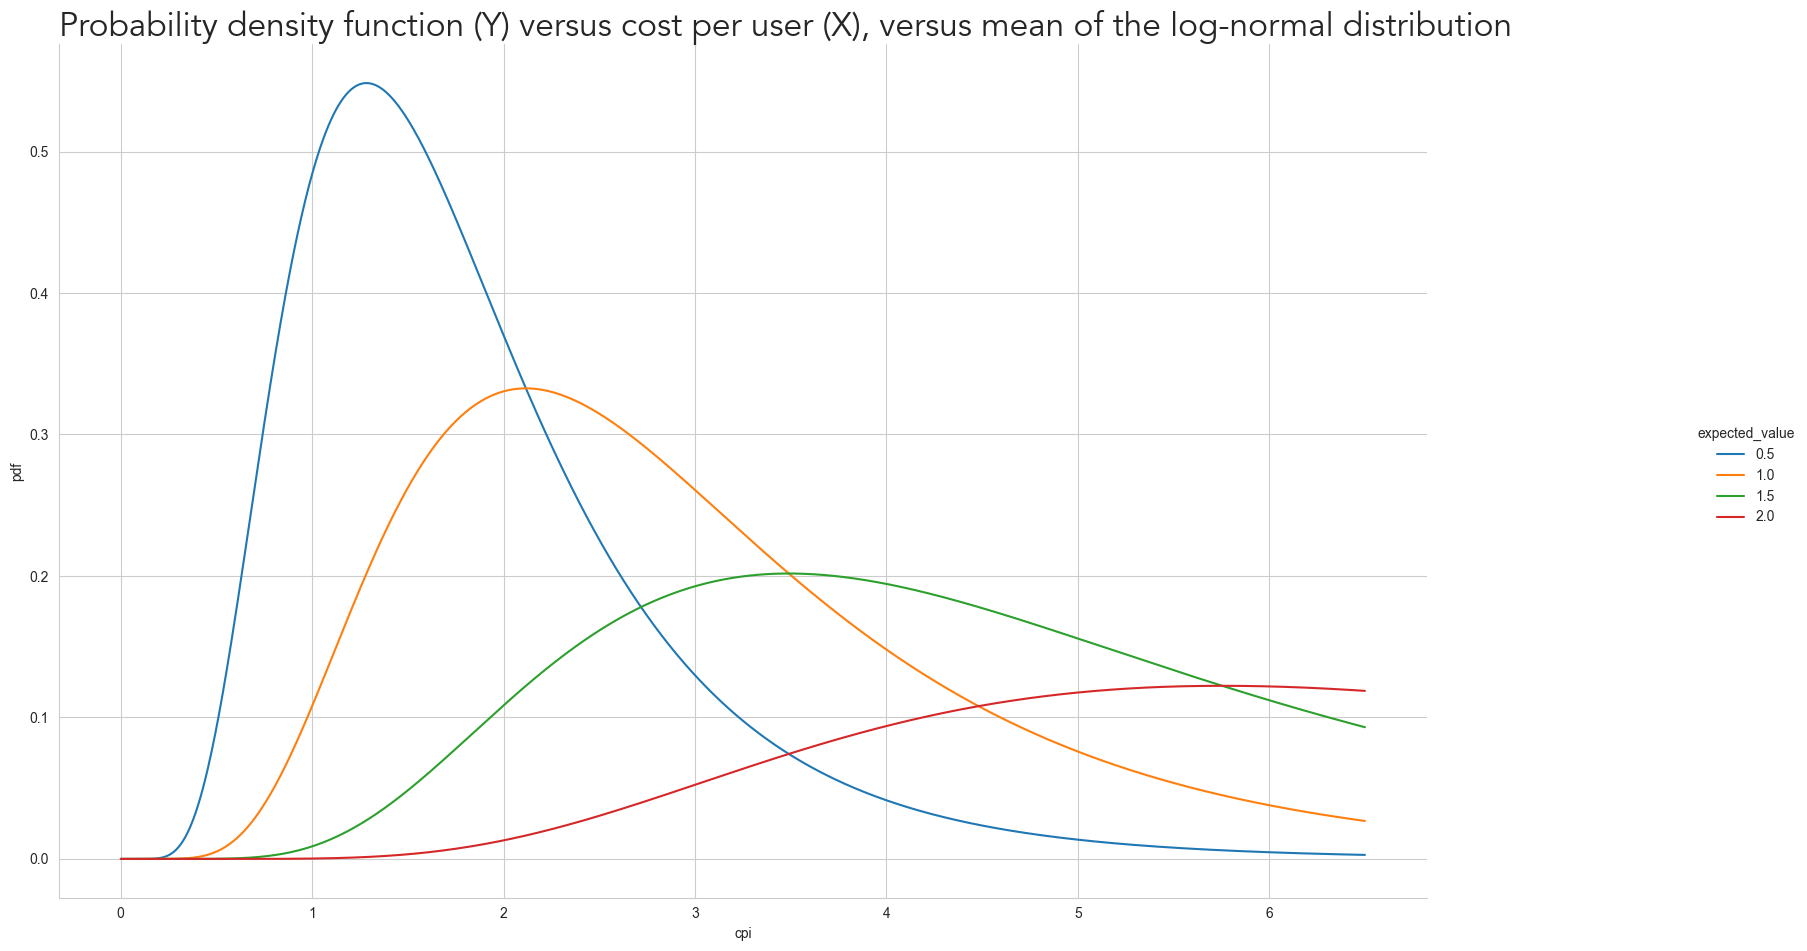

In [28]:
grid = sns.relplot(log_norm_volume_data, x='cpi', y='pdf', hue='expected_value', kind='line')
grid.figure.set_size_inches(PLOT_WITHD_INCHES, PLOT_HEIGHT_INCHES)
plt.title(
    'Probability density function (Y) versus cost per user (X), versus mean of the log-normal distribution', 
    font='Avenir', 
    fontsize=24, 
    loc='left'
)

In [29]:
log_norm_volume_data = log_norm_volume_data[log_norm_volume_data['cpi']< 2.5]

Text(0.0, 1.0, 'Number of installs (Y) versus cost per install (X), versus mean of the log-normal distribution')

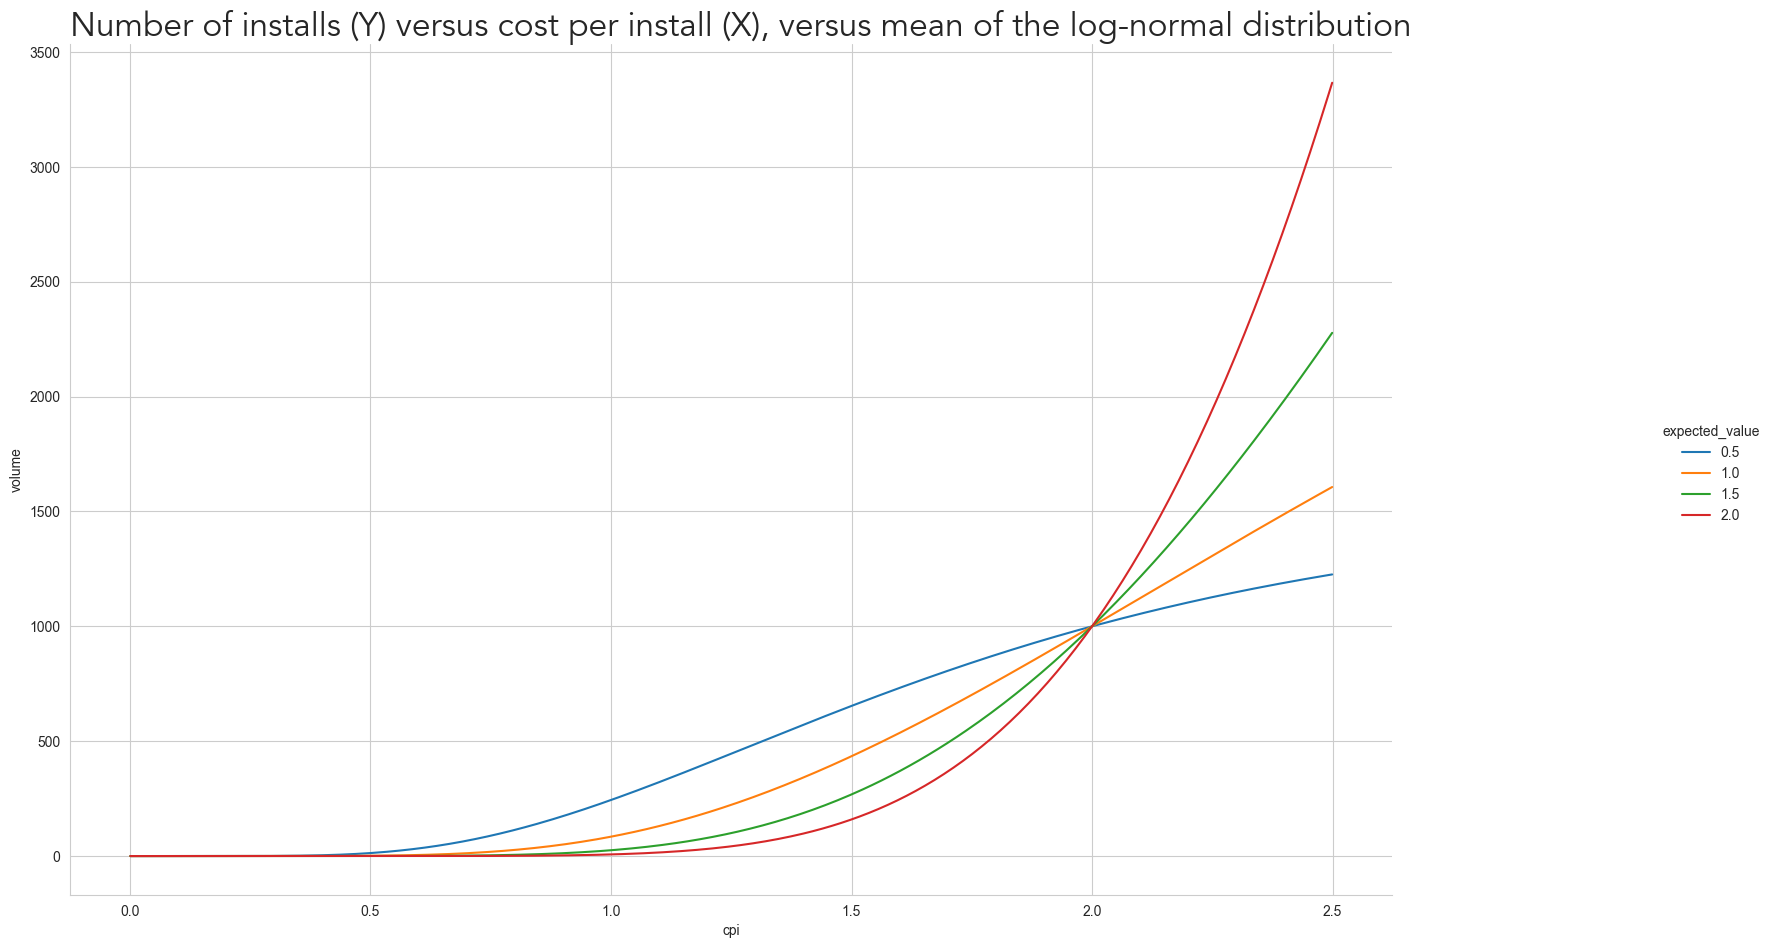

In [30]:
grid = sns.relplot(log_norm_volume_data, x='cpi', y='volume', hue='expected_value', kind='line')
grid.figure.set_size_inches(PLOT_WITHD_INCHES, PLOT_HEIGHT_INCHES)
plt.title(
    'Number of installs (Y) versus cost per install (X), versus mean of the log-normal distribution', 
    font='Avenir', 
    fontsize=24, 
    loc='left')

Each curve can represent different advertisement platforms: the blue curve could be a small platform where most users can already be acquired with a relatively low cost of \\$4, while the red curve can represent a platform with many users and a lot of competition from other advertisers since there are a lot of users we can acquire - as the curve quickly increases after \\$2.

## 3- The Profit Curve: how the expected profit varies per *Cost per User*

By using these curves in the $Profit$ function, we get the following profit curve by cost per user. 

Text(0.0, 1.0, 'Predicted expected profit (Y) versus cost per install (X), versus mean of the log-normal distribution')

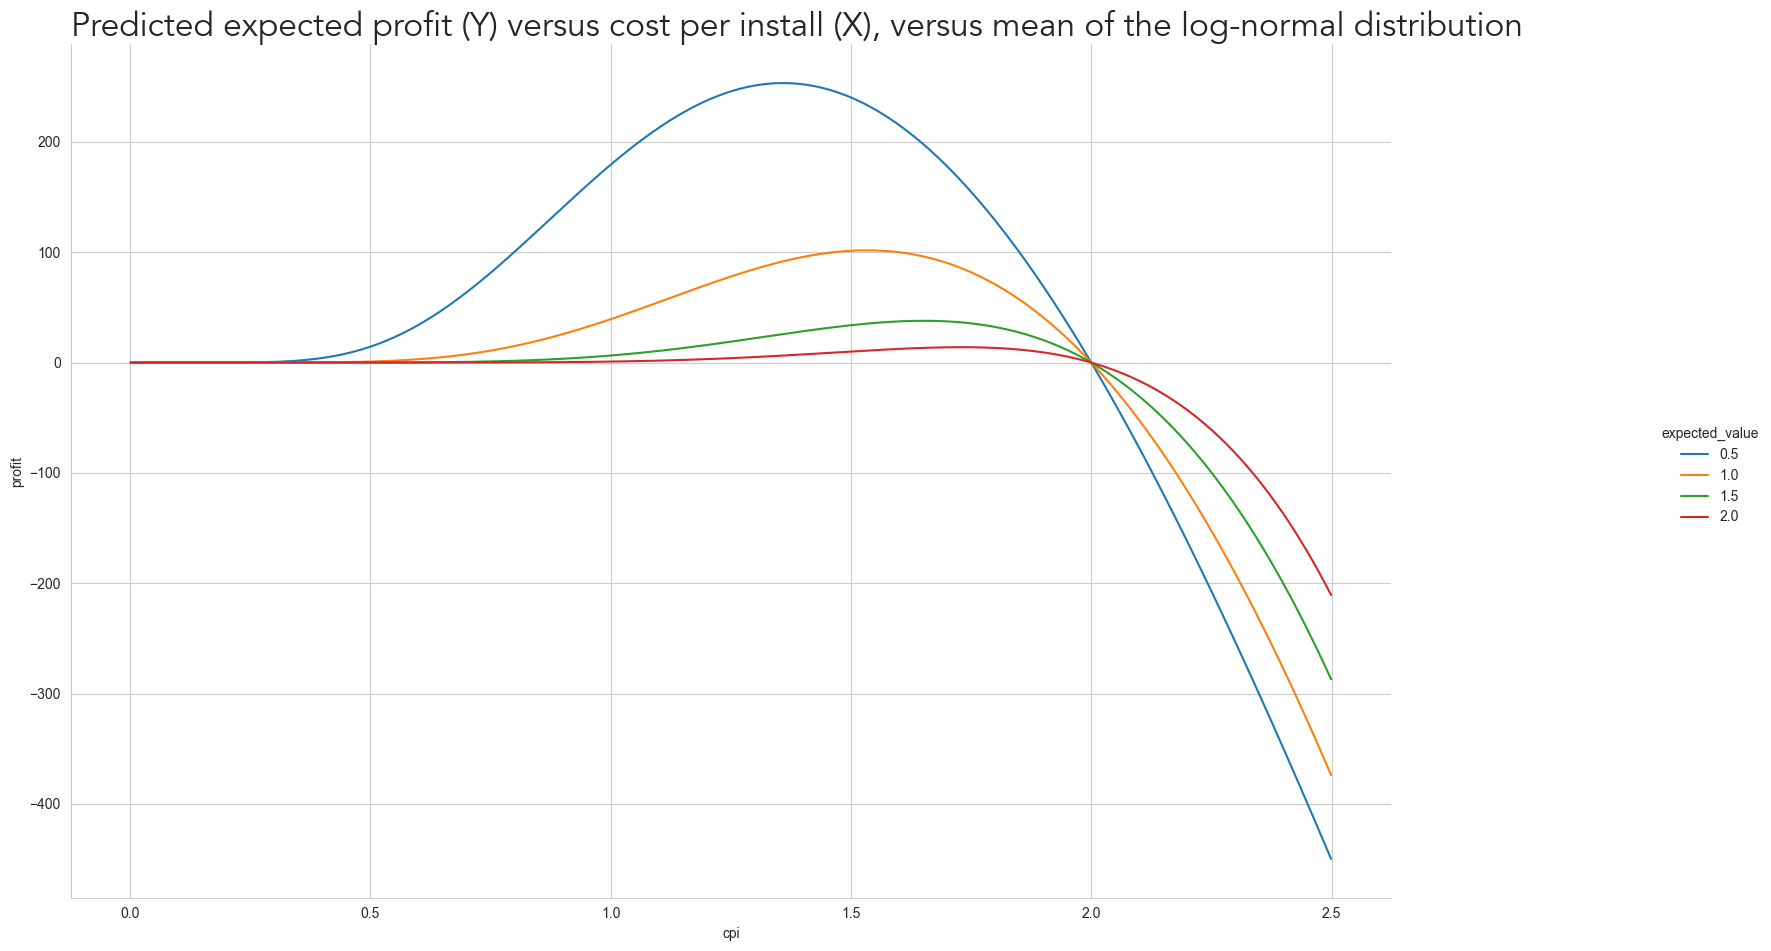

In [24]:
grid = sns.relplot(log_norm_volume_data, x='cpi', y='profit', hue='expected_value', kind='line')
grid.figure.set_size_inches(PLOT_WITHD_INCHES, PLOT_HEIGHT_INCHES)
plt.title(
    'Predicted expected profit (Y) versus cost per install (X), versus mean of the log-normal distribution', 
    font='Avenir', 
    fontsize=24, 
    loc='left')

Which all have slightly different optimal $Cost_{user}$

In [9]:
log_norm_volume_data.sort_values(['expected_value', 'profit']).groupby(['expected_value'])['cpi'].last().reset_index()

,expected_value,cpi
0,0.5,1.360651
1,1.0,1.536299
2,1.5,1.653398
3,2.0,1.731464


While the highest profit isn't relevant when comparing the curves, since we forced all the curves to provide the same number of users at \\$2, the 'shape' is. Notice how the profit curve drawn above is asymmetric around the optimal $Cost_{user}$ for most curves, as the profit quickly drops as the $Cost_{user}$ increases from its optimal point. This asymmetry will be essential to understand why and when the uncertainty on LTV matters.

## 4- The error associated with the predicted LTV

With the clear connection between *Cost per User* and profit, we can focus on LTV. The Lifetime Value of a user is, by definition, how much revenue a user generates in their lifetime, in other words, from the moment they started their 'life' as a user of a product until infinity. But we can't use infinity in practice, in good part because we need a target to train the machine-learning models, so the lifetime value is usually defined as just a date 'sufficiently away' in the future.

The fact that the 'real' LTV is usually too far away in the future means that it cannot be used for practically any critical decision within a company. This means that the LTV used for such decisions will be an estimate, and as an estimate, we are sure of its exact value.

If we estimate the LTV of our users using any conventional machine-learning algorithm, one assumption that these models require is for the residual (basically the error) to be normally distributed. As such, we will assume that the LTV models' error is (1) unbiased and (2) follow a normal distribution.

$$LTV \sim N(\mu, \sigma) $$

$$LTV_{predicted} = LTV + \epsilon$$ 

$$\epsilon \sim N(0, \delta)$$

, where $\epsilon$ is the residual and $\delta$ is its standard devitiation. 



Text(0.0, 1.0, 'Distribution of the error of the LTV predictions')

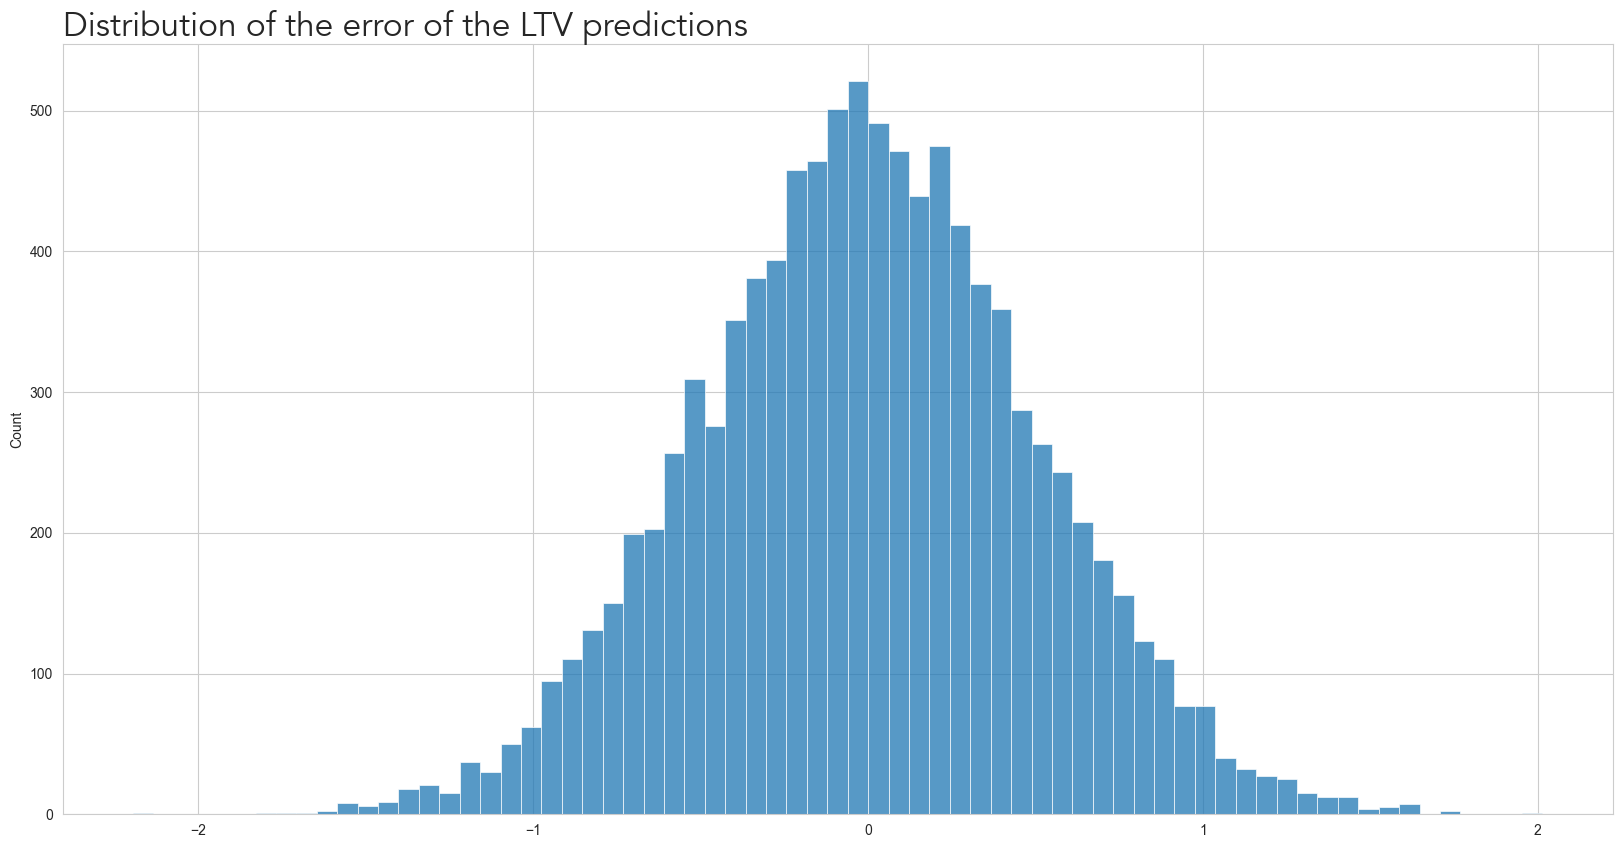

In [32]:
rng = np.random.default_rng(42)
ltv_error_std = 0.5
norm_dist = rng.normal(0, ltv_error_std, 10000)

grid = sns.histplot(norm_dist)
grid.figure.set_size_inches(PLOT_WITHD_INCHES, PLOT_HEIGHT_INCHES)
plt.title(
    'Distribution of the error of the LTV predictions', 
    font='Avenir', 
    fontsize=24, 
    loc='left')

Again, I will reinforce that LTV is a predicted metric, and as such **until proven otherwise, it is what we believe to be true**. That is the case for any metric, but for most metrics, ML models predict, it becomes clear relatively fast if the model was wrong or not. But it can take many months until signs appear of bias in the LTV predictions, which can mean **several thousand, if not tens or hundreds of thousands of dollars, invested in marketing that are not coming back**

For example, assume five different scenarios where we keep the actual LTV at 2 dollars and use the *Volume Function* in orange from the first plot but have the estimated LTV to be \\$1, \\$1.5, \\$2, \\$2.5, or \\ $3. If we know the *Volume Function* and we were to optimize for the predicted expected value of LTV without budget being a constrain, we would operate at the indicated *estimated optimal cpi*, believe we would obtain the *estimated profit* while in practice it would be the *real profit*

In [11]:
possible_ltvs = [1, 1.5, 2, 2.5, 3, 3.5]
fixed_cpi = [1]
estimated_optimal_cpi = []
for ltv in possible_ltvs:
    marketing_data = generate_marketing_properties(
        cpi_range,
        CumulativeLognormalVolume,
        fixed_cpi,
        reference_volume,
        reference_cpi,
        ltv
    )
    estimated_optimal_cpi.append(list(marketing_data.sort_values(['profit'])['cpi'])[-1])

estimated_optimal_cpi = pd.DataFrame({'cpi': estimated_optimal_cpi, 'estimated_ltv': possible_ltvs})

estimated_optimal_cpi = pd.merge(
    log_norm_volume_data[log_norm_volume_data['expected_value'] == '1.0'],
    estimated_optimal_cpi,
    on='cpi'
)
estimated_optimal_cpi['estimated profit'] = (estimated_optimal_cpi['estimated_ltv'] - estimated_optimal_cpi['cpi'])*estimated_optimal_cpi['volume']
estimated_optimal_cpi['real profit'] = estimated_optimal_cpi['profit']

|estimated_ltv | cpi | volume | estimated  profit | real profit|
|:---------|:------------|:------------|:--------------|:--------------|
|1.0	| 0.840210	| 34.971618	| 5.588107	| 40.559725|
|1.5	| 1.204519	| 191.985179	| 56.728065	| 152.720654|
|2.0	| 1.536299	| 470.453096	| 218.149430	| 218.149430|
|2.5	| 1.829047	| 793.685368	| 532.525541	| 135.682857|
|3.0	| 2.095773	| 1117.805605	| 1010.750263	| -107.055342|
|3.5	| 2.336476	| 1412.857895	| 1643.893396	| -475.393446|



Notice the discrepancy between the estimated and actual profits when we overestimate LTV. While this discrepancy is minor when the predicted LTV is underestimated (and usually, getting more money than expected isn't badly received news), the disparity quickly increases when the predictions are overestimated. 

This behavior can be better understood when we plot the profit distribution when the standard deviation is 1 (i.e., 50% of the actual LTV). As shown below, while the profit is mostly positive, we have a situation where it is negative, as demonstrated by the long left tail.

Text(0.0, 1.0, 'Distribution of the profit when the LTV error is normally distributed with average 0 and standard deviation equal to 0.8')

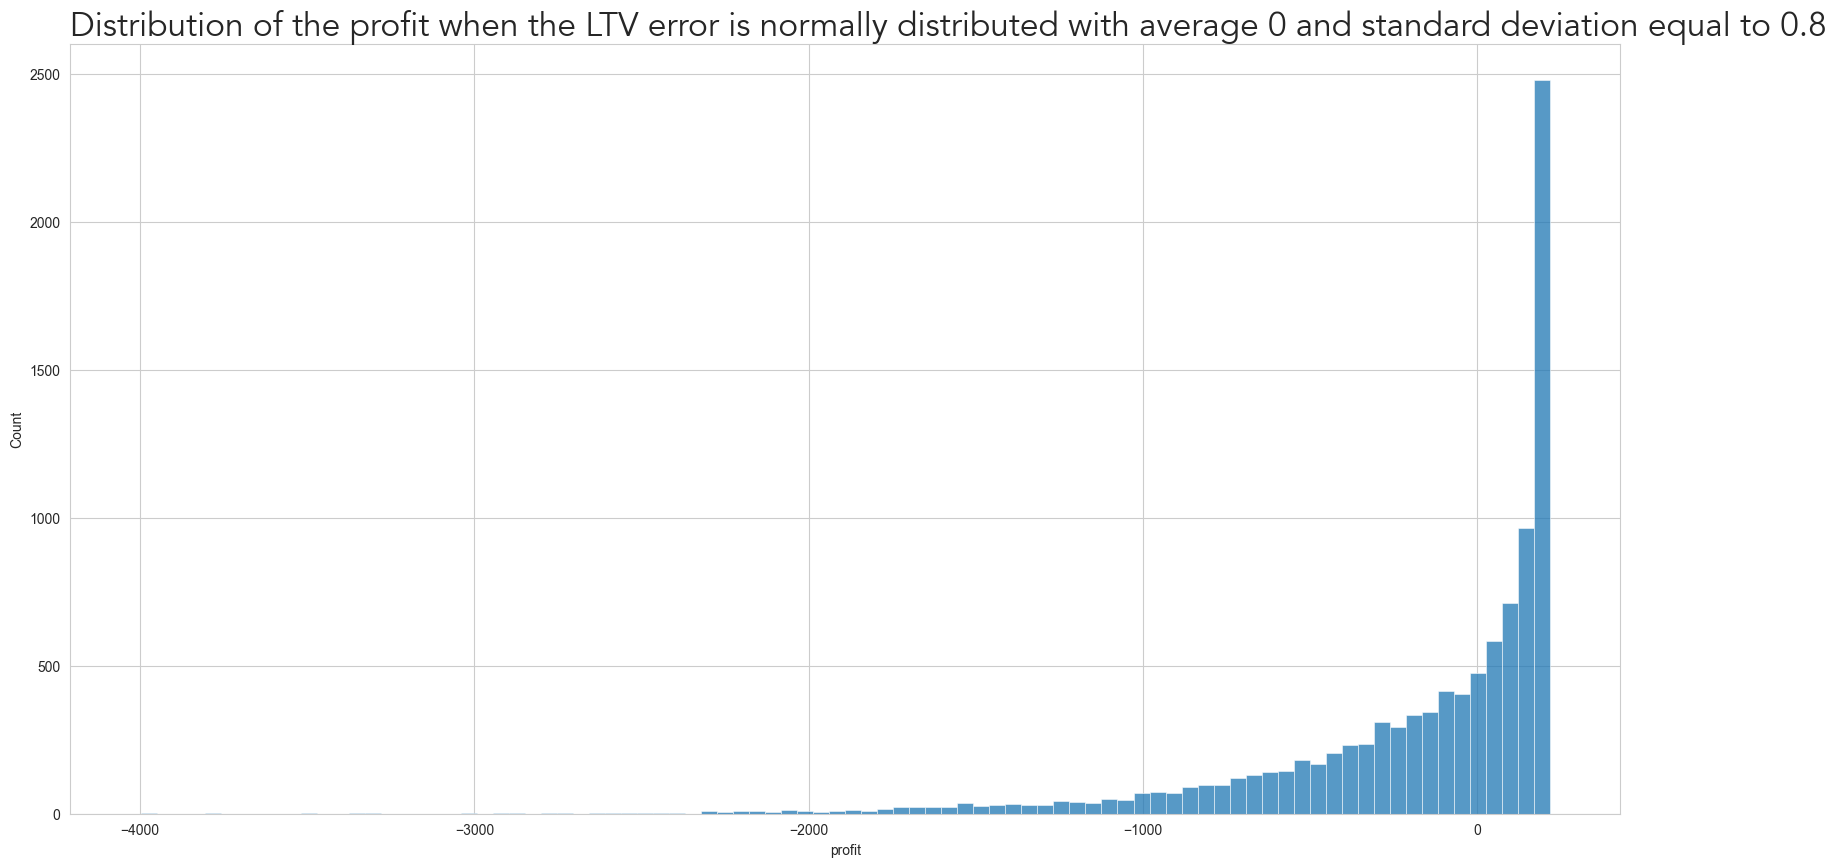

In [31]:
# See how the distribution of the profit is, when we are wrong about the LTV
from src.BidOptimizer import StandardBidOptimizer

volume_model = CumulativeLognormalVolume(reference_volume, reference_cpi, average=1, standard_deviation=0.5)
bid_optim = StandardBidOptimizer(
    volume_model, 
    std_values=[ltv_error_std], 
    ltv_fractions=[1])
bid_optim.simulate()
profit_distribution = bid_optim.results['profit']

grid = sns.histplot(profit_distribution)
grid.figure.set_size_inches(PLOT_WITHD_INCHES, PLOT_HEIGHT_INCHES)
plt.title(
    f'Distribution of the profit when the LTV error is normally distributed with average 0 and standard deviation equal to {ltv_error_std*reference_ltv}', 
    font='Avenir', 
    fontsize=24, 
    loc='left')

While one may think that a 50\% error for a prediction is too high, that is quite common for a new product being launched, for a marketing platform being introduced, or for a novel optimization within an existing platform, where there may not be much data. So given the risk involved in incorrectly predicting and specially overestimating the LTV, how should we adapt the bidding strategy change for different degrees of uncertainty?

# 5- Bidding Strategy

Under circumstances where LTV is uncertain, how should we adapt our bidding strategy to maximize the actual profit? A straightforward approach is **bidding a fraction of the estimated LTV**. The challenge is what fraction is ideal under each circumstance. 

For that goal, we simulate the previous situation 10000 for each combination of LTV uncertainty, defined by the standard deviation of the error, and *Volume Function* while always assuming that our LTV is unbiased. In each simulation, we
1) sample the LTV error from a normal distribution, with an expected value of 0 and standard deviation being a fraction from 0 to 0.4 of the actual LTV
2) we multiply the estimated LTV by a fraction of the LTV, which can be from 0.3 to 1.2, and define it as the new estimated LTV
3) with this LTV and the knowledge of the *Volume Function*, we estimate the optimal *Cost per User*
4) we use this *Cost per User* and obtain the actual profit
5) We calculate the average profit for each (Error Standard Deviation, *Volume Function*, LTV Fraction)
6) Then we see which LTV fraction provides the highest average profit for each (Error Standard Deviation, *Volume Function*)



In [33]:
sample_size = 10000
standard_deviation_of_ltv_error = np.linspace(0.001, 0.4, 10)
fraction_of_estimated_ltv = np.linspace(0.3, 1.2, 20)

output_data = []
for avg in lognormal_exp_values:
    volume_model = CumulativeLognormalVolume(reference_volume, reference_cpi, avg, .5)
    bid_optim = StandardBidOptimizer(
        volume_model, 
        standard_deviation_of_ltv_error, 
        fraction_of_estimated_ltv, 
        sample_size=sample_size)
    bid_optim.run()
    bid_optim.bidding_strategy_data['lognormal_avg'] = avg
    output_data.append(bid_optim.bidding_strategy_data)

/Users/raphaeltamaki/Documents/personal_git/lifetime_value_forecasting/src/BidOptimizer.py:69: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  self.bidding_strategy_data = self.bidding_strategy_data.groupby('sd')['mean_profit', 'std_profit', 'ltv_fraction'].first().reset_index()
/Users/raphaeltamaki/Documents/personal_git/lifetime_value_forecasting/src/BidOptimizer.py:69: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  self.bidding_strategy_data = self.bidding_strategy_data.groupby('sd')['mean_profit', 'std_profit', 'ltv_fraction'].first().reset_index()
/Users/raphaeltamaki/Documents/personal_git/lifetime_value_forecasting/src/BidOptimizer.py:69: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  self.bidding_strategy_data = self.bidding_strategy_data.grou

Text(0.0, 1.0, 'Fraction of Cost per User with highest average profit when there is not uncertainty (Y) versus error level of LTV (X), versus expected CPI for the log-normal distribution')

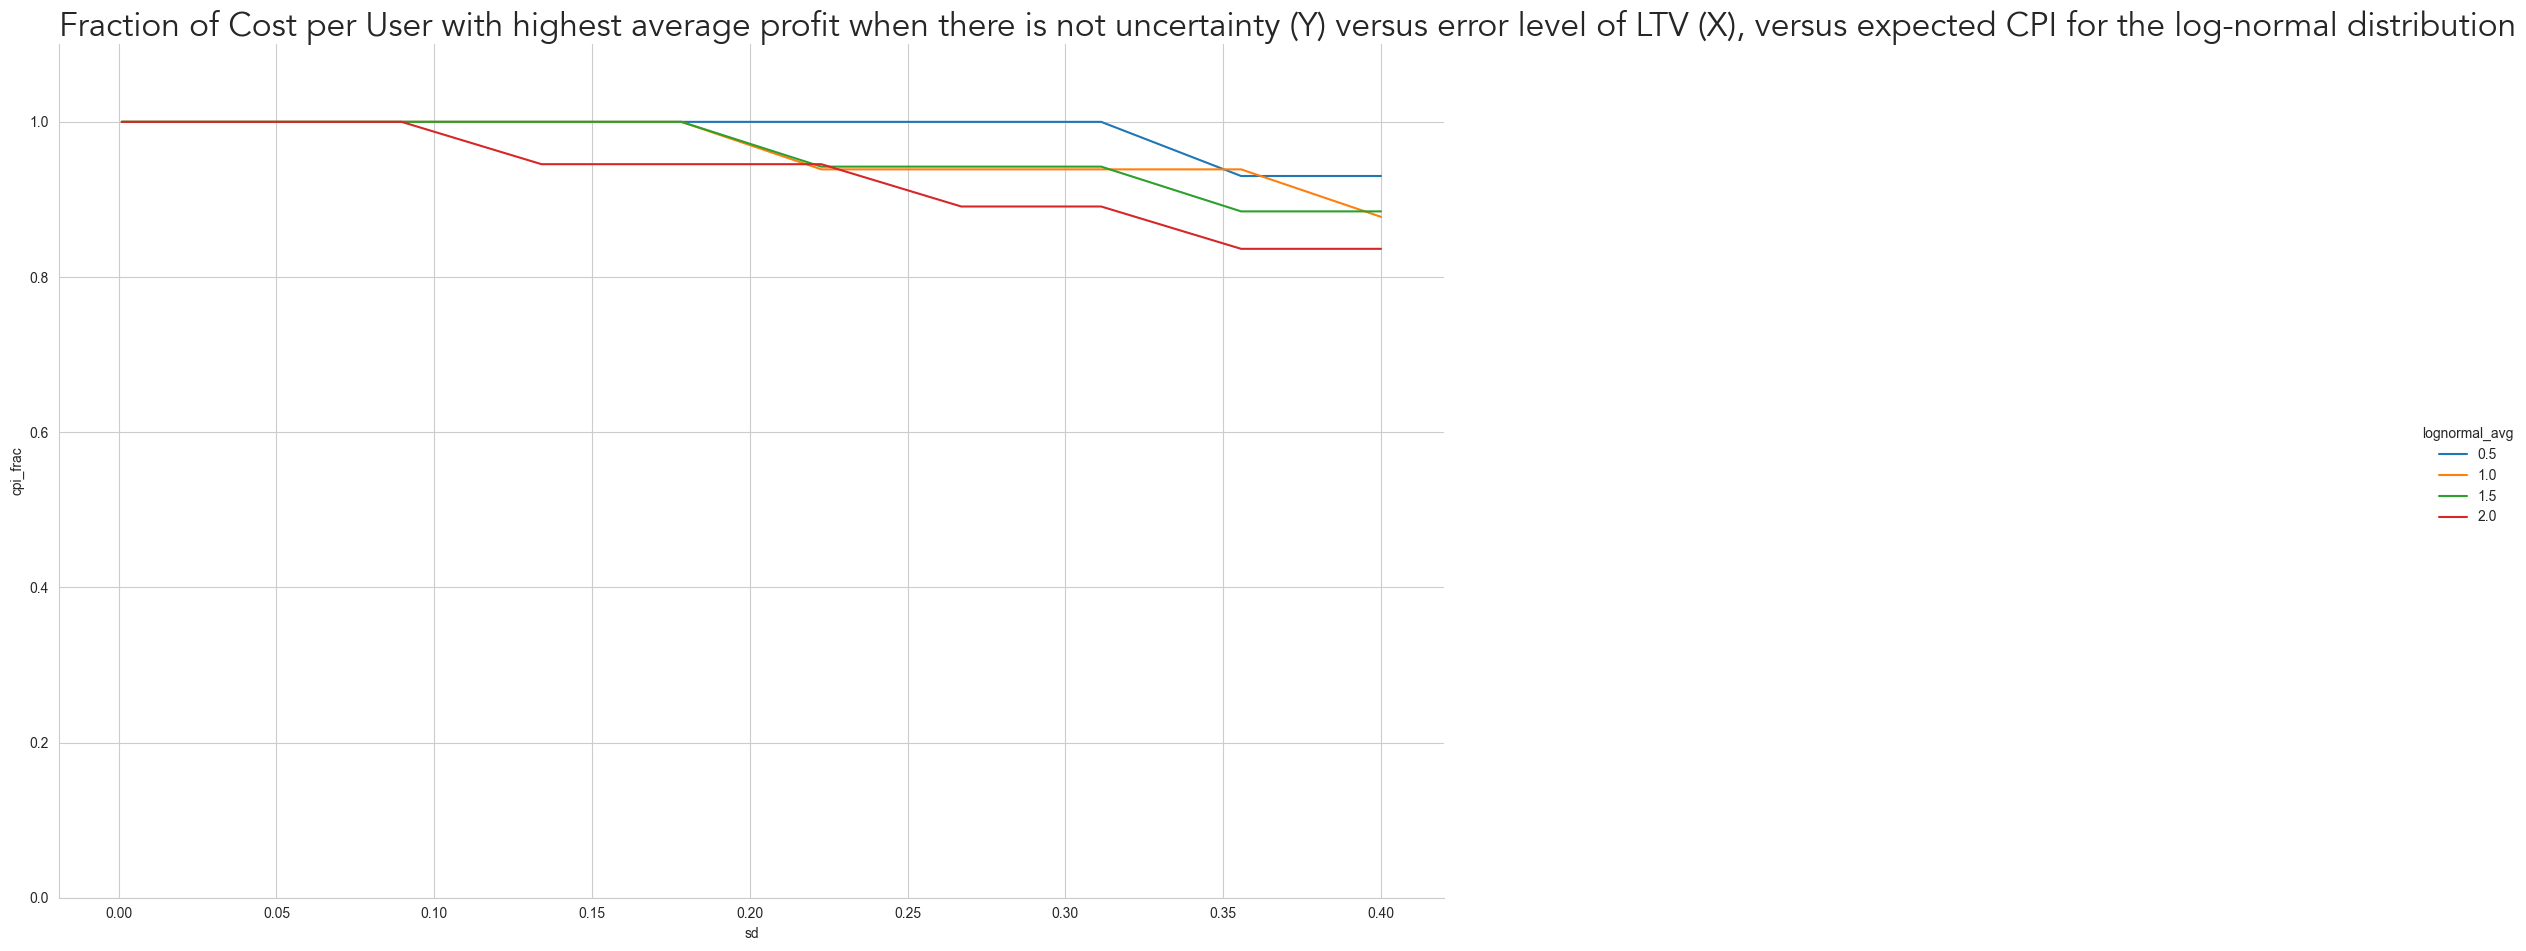

In [34]:
plot_data = pd.concat(output_data)

plot_data['lognormal_avg'] = plot_data['lognormal_avg'].astype(str)
plot_data = plot_data.sort_values(['lognormal_avg', 'sd'])
temp_data = plot_data.groupby(['lognormal_avg'])['ltv_fraction'].max().reset_index()
plot_data = pd.merge(plot_data, temp_data, on=['lognormal_avg'])
plot_data['cpi_frac'] = plot_data['ltv_fraction_x'] / plot_data['ltv_fraction_y']


grid = sns.relplot(plot_data, 
                   x='sd', 
                   y='cpi_frac', 
                   hue='lognormal_avg', 
                   kind='line', 
                   facet_kws={'ylim': [0, 1.1]}
                  )
grid.figure.set_size_inches(PLOT_WITHD_INCHES, PLOT_HEIGHT_INCHES)
plt.title(
    'Fraction of Cost per User with highest average profit when there is not uncertainty (Y) versus error level of LTV (X), versus expected CPI for the log-normal distribution', 
    font='Avenir', 
    fontsize=24, 
    loc='left')

As expected, the greater the uncertainty of LTV, the more 'conservative' we should be on our marketing strategy. But that doesn't only depend on the LTV uncertainty itself but also on the *Volume Function*. For *Volume Functions* where the profit curve is highly asymmetric around the optimal *Cost per User*, such as when $lognormal_{avg}$ is 2 (red), even for a slight standard error of 0.1 we already have to bid less than the expected optimal point. However, we don't need to be as conservative when the Profit Curve is more symmetric (or the volume doesn't increase as fast).

# 6- Conclusion

We demonstrated, under reasonable assumptions, that the LTV error and the Volume Function affect the expected profitability of market campaigns. We showed that the profit curve has different shapes depending on the Volume Function and becomes quite asymmetric around its optimal operation point.

As a consequence of this asymmetry, overestimation in the context of LTV prediction is much more dangerous than underestimation: the amount of money lost by overestimating a given amount is more significant than the unexpected money earned when we underestimate it by the same intensity.

Consequently, operating at a Cost per User below the expected optimum point is often beneficial. How much below it will depend on both the accuracy of the LTV predictions and how many more users can be acquired by an increase in the *Cost per User*